## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import cv2
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [2]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np

Using TensorFlow backend.


## Visualizing the Data

In [3]:
img1 = cv2.imread('./train/with_mask/-110603108-gettyimages-533567012.jpg')

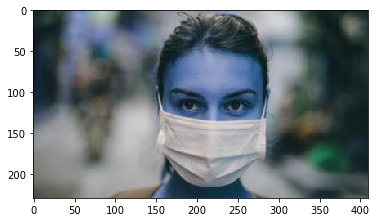

In [4]:
plt.imshow(img1)

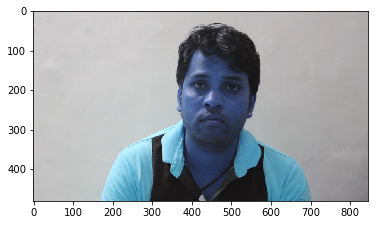

In [5]:
img2 = cv2.imread('./train/without_mask/1.jpg')
plt.imshow(img2)

In [6]:
img1.shape

(230, 410, 3)

In [7]:
img2.shape

(480, 846, 3)

## Creating the Model

In [8]:
model = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 100)     2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 100)       90100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 129600)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 129600)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6480050   
__________

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [10]:
TRAINING_DIR = "./train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')



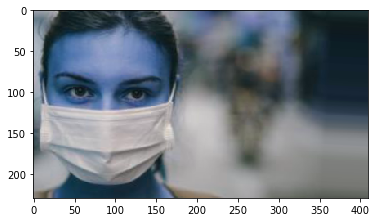

In [11]:
plt.imshow(train_datagen.random_transform(img1))

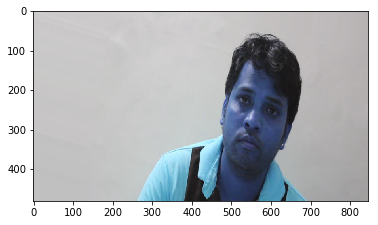

In [12]:
plt.imshow(train_datagen.random_transform(img2))

## Generating many manipulated images from a directory

In [13]:
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))


Found 1314 images belonging to 2 classes.


In [14]:
VALIDATION_DIR = "./test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))

Found 194 images belonging to 2 classes.


## Training the Model

In [15]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

In [ ]:
model.save('wieghts.h5')

In [1]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("./wieghts.h5")

results={0:' mask detected',1:' without mask'}
GR_dict={1:(0,0,255),0:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0)
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# writer = cv2.VideoWriter('maskDetection1.mp4',cv2.VideoWriter_fourcc(*'DVIX'),20,(width,height))


haarcascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt2.xml')

while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    
    if len(faces)>0:
        for f in faces:
            (x, y, w, h) = [v * rect_size for v in f] 

            face_img = im[y:y+h, x:x+w]
            rerect_sized=cv2.resize(face_img,(150,150))
            normalized=rerect_sized/255.0
            reshaped=np.reshape(normalized,(1,150,150,3))
            reshaped = np.vstack([reshaped])
            result=model.predict(reshaped)


            label=np.argmax(result,axis=1)[0]

            cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
            cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)





            cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    else :
        
        cv2.putText(im, results[0], (200,400),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
    
#     writer.write(im)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

# writer.release()

cv2.destroyAllWindows()

Using TensorFlow backend.
